In [213]:
# IMPORT LIBRAIRIES

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

In [214]:
# IMPORT DATA

btc = yf.download(tickers = 'BTC-USD')[['Close']]
btc.index = pd.DatetimeIndex(btc.index.values, freq = btc.index.inferred_freq)

[*********************100%***********************]  1 of 1 completed


In [215]:
# CHECK DATA

btc.head()

,Close
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014


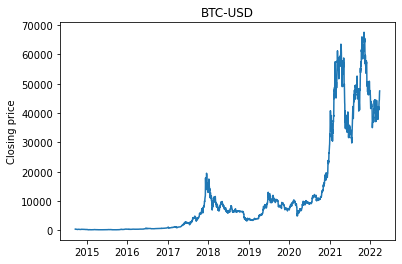

In [216]:
# PLOT DATA

fig = plt.figure()
ax = fig.add_subplot(111)
sns.lineplot(x = btc.index, y='Close', data = btc, ax = ax)
ax.set_title('BTC-USD')
ax.set_ylabel('Closing price')
plt.show()

In [217]:
# Let's consider only data since Jan 2021
idx_todrop = pd.date_range(start = btc.iloc[0].name.date(), end = '2021-12-31')
btc.drop(idx_todrop, inplace=True)

/var/folders/lc/q1lfsr356d11n9j92x9l_x080000gn/T/ipykernel_80924/2480330467.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc.drop(idx_todrop, inplace=True)


In [218]:
btc.head()

,Close
2022-01-01,47686.812500
2022-01-02,47345.218750
2022-01-03,46458.117188
2022-01-04,45897.574219
2022-01-05,43569.003906


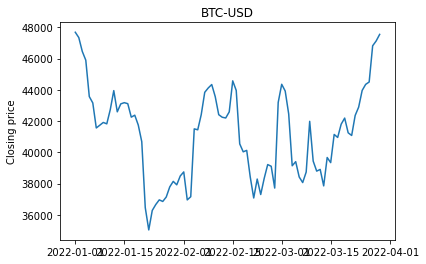

In [219]:
fig = plt.figure()
ax = fig.add_subplot(111)
sns.lineplot(x = btc.index, y='Close', data = btc, ax = ax)
ax.set_title('BTC-USD')
ax.set_ylabel('Closing price')
plt.show()

In [220]:
# CHECK STATIONARITY
# From the graph above, we can definitely conclude that there is no stationarity.
# Let's confirm this with ADFULLER and KPSS tests.

# ADFULLER
from statsmodels.tsa.stattools import adfuller

result = adfuller(btc.Close)
print('ADF Test Statistic: %.2f' % result[0])
print('5%% Critical Value: %.2f' % result[4]['5%'])
print('p-value: %.2f' % result[1])

ADF Test Statistic: -2.36
5% Critical Value: -2.90
p-value: 0.15


In [221]:
# p-value of 0.11: the time series is not stationary.

In [222]:
# KPSS
from statsmodels.tsa.stattools import kpss

result = kpss(btc.Close)
print(result)
print('KPSS Test Statistic: %.2f' % result[0])
print('5%% Critical Value: %.2f' % result[3]['5%'])
print('p-value: %.2f' % result[1])

(0.15306325593771658, 0.1, 5, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
KPSS Test Statistic: 0.15
5% Critical Value: 0.46
p-value: 0.10


/Users/ericmartinet/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [223]:
# p-value above 0.10: the time series is stationary.

# KPSS indicates stationarity and ADF indicates non-stationarity - The series is trend stationary.
# Trend needs to be removed to make series strict stationary. 
# Let's create a function to make the time series stationary.

def make_stationary(time_series, diff_depth = 10):
    for i in range(1, diff_depth+1):
        time_series_stationary = time_series.diff(periods = i).dropna()
        if (adfuller(time_series_stationary)[1] < 0.05) and (kpss(time_series_stationary)[1] > 0.05):
            print(f'Stationary time series found with differenciating depth of {i}.')
            return time_series_stationary
    return None

btc['Close_stationary'] = make_stationary(btc.Close)

if not btc.Close_stationary.any():
    print('Please increase depth of differenciation.')

Stationary time series found with differenciating depth of 1.


/Users/ericmartinet/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/var/folders/lc/q1lfsr356d11n9j92x9l_x080000gn/T/ipykernel_80924/1061917828.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc['Close_stationary'] = make_stationary(btc.Close)


In [224]:
btc.head()

,Close,Close_stationary
2022-01-01,47686.812500,NaN
2022-01-02,47345.218750,-341.593750
2022-01-03,46458.117188,-887.101562
2022-01-04,45897.574219,-560.542969
2022-01-05,43569.003906,-2328.570312


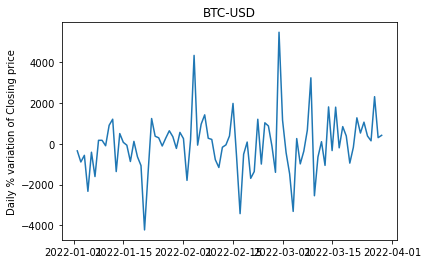

In [225]:
# PLOT DATA

fig = plt.figure()
ax = fig.add_subplot(111)
sns.lineplot(x = btc.index, y='Close_stationary', data = btc, ax = ax)
ax.set_title('BTC-USD')
ax.set_ylabel('Daily % variation of Closing price')
plt.show()

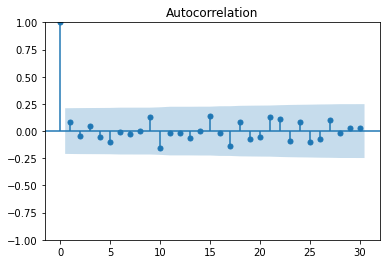

In [229]:
# CHECK AUTO-CORRELATION
from statsmodels.graphics.tsaplots import plot_acf
# Calculate the ACF (via statsmodel)
plot_acf(btc.Close_stationary.dropna(), alpha =0.05, lags=30)
# Show the data as a plot (via matplotlib)
plt.show()

In [227]:
# No auto-correlation of the stationary time series

/Users/ericmartinet/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


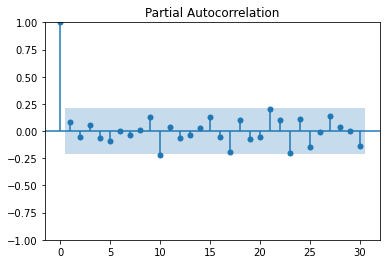

In [230]:
# PARTIAL AUTO-CORRELATION
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(btc.Close_stationary.dropna(), alpha =0.05, lags= 30)
plt.show()

In [ ]:
# No partial auto-correlation of the stationary time series

In [231]:
# The time series is now stationary and not auto-correlated, we can implement AR and MA models

from statsmodels.tsa.arima.model import ARIMA
from sklearn import metrics


def implement_arima_model(data, order):
    model = ARIMA(data, order = order, freq = 'D')
    results = model.fit()
    p = order[0]
    d = order[1]
    q = order[2]
    y_true = data.values
    y_pred = results.predict(n_periods = len(data))
    if p>0:
        if q>0:
            if d>0:
                model_name = f'ARIMA({p},{d},{q})'
            else:
                model_name = f'ARMA({p},{q})'
        else:
            model_name = f'AR({p})'
    else:
        model_name = f'MA({q})'
    MAE = metrics.mean_absolute_error(y_true=y_true, y_pred = y_pred)
    MAPE = metrics.mean_absolute_percentage_error(y_true=y_true, y_pred = y_pred)
    MSE = metrics.mean_squared_error(y_true=y_true, y_pred = y_pred)
    RMSE = np.sqrt(metrics.mean_squared_error(y_true=y_true, y_pred = y_pred))
    NRMSE = np.sqrt(metrics.mean_squared_error(y_true=y_true, y_pred = y_pred)) / (np.max(y_true) - np.min(y_true))
    AIC = results.aic
    BIC = results.bic
    return [model_name, MAE, MAPE, MSE, RMSE, NRMSE, AIC, BIC]
    
cols = ['MAE', 'MAPE', 'MSE', 'RMSE', 'NRMSE', 'AIC', 'BIC']

df_model_comparison = pd.DataFrame(columns = cols)

# AR(1) to AR(3)
for p in range(1,3+1):
    model_results = implement_arima_model(btc.Close_stationary.dropna(), order = (p,0,0))
    df_results = pd.DataFrame([model_results[1:]], index = [model_results[0]], columns = cols)
    df_model_comparison = pd.concat([df_model_comparison, df_results])

# MA(1) to MA(3)
for q in range(1,3+1):
    model_results = implement_arima_model(btc.Close_stationary.dropna(), order = (0,0,q))
    df_results = pd.DataFrame([model_results[1:]], index = [model_results[0]], columns = cols)
    df_model_comparison = pd.concat([df_model_comparison, df_results])

df_model_comparison


,MAE,MAPE,MSE,RMSE,NRMSE,AIC,BIC
AR(1),971.040425,1.074091,2006893.61569,1416.648727,0.145948,1515.459521,1522.857246
AR(2),967.477172,1.055473,2000535.049147,1414.402718,0.145716,1517.197709,1527.061341
AR(3),965.034168,1.050872,1994530.144653,1412.278352,0.145497,1518.964367,1531.293908
MA(1),968.942251,1.075447,2005056.62091,1416.000219,0.145881,1515.380844,1522.778568
MA(2),965.867961,1.060297,1997713.093938,1413.404788,0.145613,1517.130462,1526.994094
MA(3),962.343652,1.042315,1994094.506249,1412.124111,0.145482,1519.100126,1531.429667


In [ ]:
# These models are all very similar, and not very performant.

In [232]:
# ARMA(1,1) to ARMA(3,3)
for p in range(1, 3+1):
    for q in range(1,3+1):
        model_results = implement_arima_model(btc.Close_stationary.dropna(), order = (p,0,q))
        df_results = pd.DataFrame([model_results[1:]], index = [model_results[0]], columns = cols)
        df_model_comparison = pd.concat([df_model_comparison, df_results])

df_model_comparison

/Users/ericmartinet/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/ericmartinet/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/ericmartinet/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/ericmartinet/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('

,MAE,MAPE,MSE,RMSE,NRMSE,AIC,BIC
AR(1),971.040425,1.074091,2006893.61569,1416.648727,0.145948,1515.459521,1522.857246
AR(2),967.477172,1.055473,2000535.049147,1414.402718,0.145716,1517.197709,1527.061341
AR(3),965.034168,1.050872,1994530.144653,1412.278352,0.145497,1518.964367,1531.293908
MA(1),968.942251,1.075447,2005056.62091,1416.000219,0.145881,1515.380844,1522.778568
MA(2),965.867961,1.060297,1997713.093938,1413.404788,0.145613,1517.130462,1526.994094
MA(3),962.343652,1.042315,1994094.506249,1412.124111,0.145482,1519.100126,1531.429667
"ARMA(1,1)",956.527834,1.038526,1990838.059499,1410.970609,0.145363,1516.785362,1526.648995
"ARMA(1,2)",955.971019,1.044002,1975019.721605,1405.353949,0.144784,1518.140086,1530.469626
"ARMA(1,3)",961.895275,1.042954,1993561.368121,1411.935327,0.145462,1521.071771,1535.86722
"ARMA(2,1)",956.563043,1.043052,1975473.934074,1405.51554,0.144801,1518.161263,1530.490803


In [233]:
# ARIMA: using auto_arima
import pmdarima as pm
model = pm.arima.auto_arima(btc.Close, trace = True, error_action='ignore', suppress_warnings=True, seasonal = False)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2122.335, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1539.729, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1541.446, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1532.481, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1590.368, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1532.654, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1534.332, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1534.441, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1660.265, Time=0.01 s

In [234]:
model.fit(btc.Close)

ARIMA(order=(1, 0, 1), scoring_args={}, suppress_warnings=True)

In [246]:
forecast = model.predict(n_periods = 5)
forecast = pd.DataFrame(forecast, columns = ['Prediction'])
forecast.set_index(pd.date_range(start = btc.iloc[-1].name.date() + pd.DateOffset(1), end = btc.iloc[-1].name.date() + pd.DateOffset(5)), inplace = True)
forecast

,Prediction
2022-03-30,46961.119730
2022-03-31,46265.936220
2022-04-01,45668.526947
2022-04-02,45155.140432
2022-04-03,44713.959275


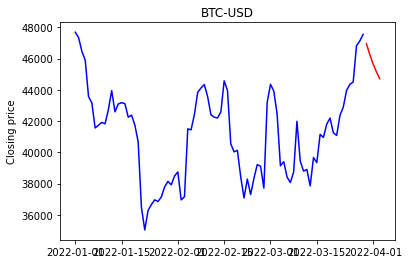

In [247]:
fig = plt.figure()
ax = fig.add_subplot(111)
sns.lineplot(x = btc.index, y='Close', data = btc, ax = ax, color = "blue")
sns.lineplot(x = forecast.index , y = 'Prediction', data = forecast, ax = ax, color = "red")
ax.set_title('BTC-USD')
ax.set_ylabel('Closing price')
plt.show()

In [ ]:
# BTC price is likely to decrease, I should not buy BTC now.